In [1]:
Name= 'Catherine Bui'
Organization= 'Center For Community Innovation'
Project= 'Twitter Displacement Study'

In [1]:
%%time
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import subprocess
from pathlib import Path
import csv
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import xlrd
import numpy as np
from io import StringIO
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric
from sqlalchemy.orm import sessionmaker
import dask.dataframe as das
import sqlite3
import datetime



CPU times: user 1.45 s, sys: 376 ms, total: 1.82 s
Wall time: 3.94 s


# ANALYZING TWEETS IN NEW YORK 
1. Compare full set of tweets a census tract level to those with home location to see differences in spatial distribution
    a. Tracts with greater/lesser share of all tweets vs home location tweets
    b. by tract, % of tweets missing home_tract
2. Summarize distribution of tweets by user - # of users with more than 5 tweets in a tract -- compare to overall distribution
3. Using tweets with home location, summary statistics of the share of tweets in a tract in the time period. 


The census of tract is the unit of metric. Home location was determined by: A home location (tract) needs to: Receive at least 10 tweetsoSent from >7 different daysoSent from 8 or more different hours of the dayoIf multiple locations satisfy, we take the location with the most tweets as the home location 

The number of rows in the original data is 75368830. 

### READING THE CSV FILE WITH DASK 
1. Clean and prepare the data

In [2]:
%%time
file = "/scratch/public/catherinebui/ny_twitter.csv"
ds = das.read_csv(file)
ds = ds.rename(columns = {'ny_with_homeloc.csv': 'id'})

CPU times: user 136 ms, sys: 8 ms, total: 144 ms
Wall time: 149 ms


### GROUPING BY TRACT 

In [3]:
groupbytract= ds.groupby('tract')

In [59]:
#SHOW THE COUNT OF TWEETS PER TRACT
groupbytract.count().head(819)

,id,u_id,lat,lon,date,home_tract,diff_tract
tract,,,,,,,
9.001010e+09,2610,2610,2610,2610,2610,2610,2610
9.001010e+09,4746,4746,4746,4746,4746,4746,4746
9.001010e+09,2953,2953,2953,2953,2953,2953,2953
9.001010e+09,15253,15253,15253,15253,15253,15226,15226
9.001010e+09,11688,11688,11688,11688,11688,11688,11688
9.001010e+09,18220,18220,18220,18220,18220,18219,18219
9.001011e+09,18168,18168,18168,18168,18168,18155,18155
9.001011e+09,3687,3687,3687,3687,3687,3687,3687
9.001011e+09,6458,6458,6458,6458,6458,6458,6458


In [5]:
idpertract= groupbytract.count().drop(['u_id', 'lat', 'lon',
                                      'home_tract', 'date'], axis =1).reset_index()
idpertract = idpertract[idpertract['tract'] != 0]
idpertract  = idpertract.rename(columns = {'id': 'total_tweets'})

In [34]:
idpertract.head(10)

,tract,id
1,9001010101,2610
2,9001010201,4746
3,9001010202,2953
4,9001010300,15253
5,9001010400,11688
6,9001010500,18220
7,9001010600,18168
8,9001010700,3687
9,9001010800,6458
10,9001010900,9573


In [10]:
idpertract.to_csv('nytract_*.csv')

['nytract_0.csv']

There are 3488 tracts in New York dataset.

2. Show the percentage of missing home tracts per tract (in decimals)

Looking for bias in home location since home location was generated, not given.

In [5]:
nullpertract = groupbytract.apply(lambda x: x.isnull().sum()/x.count())
nullpertract = nullpertract.drop(['id', 'u_id', 'lat', 'lon', 'tract', 'date'], axis = 1).rename(columns = {'home_tract': 'miss_home_tract'}).reset_index()

/usr/local/linux/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [7]:
nullpertract.head(10)

,id,u_id,lat,lon,date,tract,home_tract
tract,,,,,,,
34003042302,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
34003061300,0.0,0.0,0.0,0.0,0.0,0.0,0.000079
34013020400,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
34017006200,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
34017014600,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
34027040200,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
36005023502,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
36005037100,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
36047024100,0.0,0.0,0.0,0.0,0.0,0.0,0.000049


In [7]:
nullpertract.head(10)

,tract,miss_home_tract
0,3.400301e+10,0.000000
1,3.401302e+10,0.000000
2,3.402300e+10,0.000053
3,3.403903e+10,0.000000
4,3.600501e+10,0.001501
5,3.600502e+10,0.000000
6,3.600503e+10,0.003531
7,3.606100e+10,0.000000
8,3.606102e+10,0.000048
9,3.608100e+10,0.000000


In [7]:
nullpertract.to_csv('missing_*.csv')

['missing_000.csv',
 'missing_001.csv',
 'missing_002.csv',
 'missing_003.csv',
 'missing_004.csv',
 'missing_005.csv',
 'missing_006.csv',
 'missing_007.csv',
 'missing_008.csv',
 'missing_009.csv',
 'missing_010.csv',
 'missing_011.csv',
 'missing_012.csv',
 'missing_013.csv',
 'missing_014.csv',
 'missing_015.csv',
 'missing_016.csv',
 'missing_017.csv',
 'missing_018.csv',
 'missing_019.csv',
 'missing_020.csv',
 'missing_021.csv',
 'missing_022.csv',
 'missing_023.csv',
 'missing_024.csv',
 'missing_025.csv',
 'missing_026.csv',
 'missing_027.csv',
 'missing_028.csv',
 'missing_029.csv',
 'missing_030.csv',
 'missing_031.csv',
 'missing_032.csv',
 'missing_033.csv',
 'missing_034.csv',
 'missing_035.csv',
 'missing_036.csv',
 'missing_037.csv',
 'missing_038.csv',
 'missing_039.csv',
 'missing_040.csv',
 'missing_041.csv',
 'missing_042.csv',
 'missing_043.csv',
 'missing_044.csv',
 'missing_045.csv',
 'missing_046.csv',
 'missing_047.csv',
 'missing_048.csv',
 'missing_049.csv',


In [9]:
missing = ['missing_000.csv','missing_001.csv','missing_002.csv','missing_003.csv','missing_004.csv',
 'missing_005.csv','missing_006.csv','missing_007.csv','missing_008.csv','missing_009.csv',
 'missing_010.csv','missing_011.csv','missing_012.csv','missing_013.csv','missing_014.csv', 
 'missing_015.csv','missing_016.csv','missing_017.csv','missing_018.csv', 'missing_019.csv',
 'missing_020.csv','missing_021.csv','missing_022.csv','missing_023.csv','missing_024.csv',
 'missing_025.csv','missing_026.csv','missing_027.csv','missing_028.csv',
 'missing_029.csv','missing_030.csv','missing_031.csv','missing_032.csv','missing_033.csv',
 'missing_034.csv','missing_035.csv','missing_036.csv','missing_037.csv','missing_038.csv',
 'missing_039.csv','missing_040.csv','missing_041.csv','missing_042.csv','missing_043.csv','missing_044.csv','missing_045.csv','missing_046.csv','missing_047.csv','missing_048.csv', 'missing_049.csv',
 'missing_050.csv', 'missing_051.csv','missing_052.csv', 'missing_053.csv', 'missing_054.csv','missing_055.csv', 'missing_056.csv','missing_057.csv',
 'missing_058.csv','missing_059.csv','missing_060.csv', 'missing_061.csv',
 'missing_062.csv','missing_063.csv','missing_064.csv', 'missing_065.csv', 'missing_066.csv','missing_067.csv',
 'missing_068.csv', 'missing_069.csv', 'missing_070.csv', 'missing_071.csv','missing_072.csv', 'missing_073.csv',
 'missing_074.csv', 'missing_075.csv', 'missing_076.csv', 'missing_077.csv','missing_078.csv', 'missing_079.csv','missing_080.csv','missing_081.csv','missing_082.csv','missing_083.csv',
 'missing_084.csv', 'missing_085.csv','missing_086.csv','missing_087.csv','missing_088.csv',
 'missing_089.csv', 'missing_090.csv','missing_091.csv','missing_092.csv','missing_093.csv','missing_094.csv','missing_095.csv','missing_096.csv',
 'missing_097.csv', 'missing_098.csv','missing_099.csv','missing_100.csv','missing_101.csv',
 'missing_102.csv','missing_103.csv','missing_104.csv','missing_105.csv',
 'missing_106.csv','missing_107.csv','missing_108.csv','missing_109.csv','missing_110.csv','missing_111.csv', 'missing_112.csv','missing_113.csv','missing_114.csv','missing_115.csv',
 'missing_116.csv','missing_117.csv', 'missing_118.csv','missing_119.csv',
 'missing_120.csv', 'missing_121.csv','missing_122.csv','missing_123.csv','missing_124.csv',
 'missing_125.csv','missing_126.csv', 'missing_127.csv', 'missing_128.csv','missing_129.csv',
 'missing_130.csv','missing_131.csv','missing_132.csv']
pd.concat(pd.read_csv(f) for f in missing).to_csv('missing.csv')

In [8]:
idpertract = idpertract.merge(nullpertract, on = 'tract', how = 'inner')

In [10]:
idpertract.head(10)

,tract,id,miss_home_tract
0,3.400301e+10,13226,0.000000
1,3.401302e+10,19588,0.000000
2,3.402300e+10,67836,0.000069
3,3.403903e+10,35206,0.000000
4,3.600501e+10,11725,0.002543
5,3.600502e+10,8715,0.000000
6,3.600503e+10,10522,0.002151
7,3.606100e+10,16628,0.000000
8,3.606102e+10,27768,0.000102
9,3.608100e+10,10917,0.000000


In [ ]:
nullpertract.drop(['tract'], axis = 1).reset_index().drop(['id', 'u_id', 'lat', 
                                                          'lon', 'date'] , axis = 1)['home_tract'].compute()

## GROUPING BY ID
1. Count the number of tweets per user. Create a summary statistics

In [5]:
groupbyuid = ds.groupby('u_id')

In [9]:
#Show first 10 rows 
groupbyuid.count().drop(['lat', 'lon', 'home_tract', 
                          'tract', 'diff_tract', 'date'], axis =1).head(10)

,id
u_id,
1.668805e-308,104
1.668805e-308,953
1.668805e-308,1395
1.668805e-308,229
1.668805e-308,1286
1.668805e-308,264
1.668805e-308,760
1.668805e-308,419
1.668805e-308,494


## Per tract, how many users have more than 5 tweets? 
1. Group by tract and group by u_id. 
2. Then, filter u_id with tweets more than 5. 
3. Reset the index
4. Group by tract and get the count of users with more than 5 tweets

In [56]:
uidt = ds.groupby(['tract', 'u_id']).count()


In [ ]:
uidt[uidt['id'] > 5].head(10)

In [6]:
totalusers = groupbytract.apply(lambda x: x.nunique())
totalusers = totalusers.drop(['tract', 'id', 'lat', 'lon', 'date', 'home_tract'], axis = 1).reset_index()
totalusers = totalusers.rename(columns = {'u_id': 'total_users'})

/usr/local/linux/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [7]:
totalusers.to_csv('totalusers_*.csv')

['totalusers_000.csv',
 'totalusers_001.csv',
 'totalusers_002.csv',
 'totalusers_003.csv',
 'totalusers_004.csv',
 'totalusers_005.csv',
 'totalusers_006.csv',
 'totalusers_007.csv',
 'totalusers_008.csv',
 'totalusers_009.csv',
 'totalusers_010.csv',
 'totalusers_011.csv',
 'totalusers_012.csv',
 'totalusers_013.csv',
 'totalusers_014.csv',
 'totalusers_015.csv',
 'totalusers_016.csv',
 'totalusers_017.csv',
 'totalusers_018.csv',
 'totalusers_019.csv',
 'totalusers_020.csv',
 'totalusers_021.csv',
 'totalusers_022.csv',
 'totalusers_023.csv',
 'totalusers_024.csv',
 'totalusers_025.csv',
 'totalusers_026.csv',
 'totalusers_027.csv',
 'totalusers_028.csv',
 'totalusers_029.csv',
 'totalusers_030.csv',
 'totalusers_031.csv',
 'totalusers_032.csv',
 'totalusers_033.csv',
 'totalusers_034.csv',
 'totalusers_035.csv',
 'totalusers_036.csv',
 'totalusers_037.csv',
 'totalusers_038.csv',
 'totalusers_039.csv',
 'totalusers_040.csv',
 'totalusers_041.csv',
 'totalusers_042.csv',
 'totaluser

In [7]:
totalusers = ['totalusers_000.csv',
 'totalusers_001.csv', 'totalusers_002.csv','totalusers_003.csv', 'totalusers_004.csv','totalusers_005.csv','totalusers_006.csv',
 'totalusers_007.csv', 'totalusers_008.csv', 'totalusers_009.csv', 'totalusers_010.csv', 'totalusers_011.csv',
 'totalusers_012.csv', 'totalusers_013.csv','totalusers_014.csv','totalusers_015.csv', 'totalusers_016.csv', 'totalusers_017.csv',
 'totalusers_018.csv','totalusers_019.csv', 'totalusers_020.csv','totalusers_021.csv','totalusers_022.csv','totalusers_023.csv','totalusers_024.csv',
 'totalusers_025.csv', 'totalusers_026.csv','totalusers_027.csv','totalusers_028.csv','totalusers_029.csv','totalusers_030.csv','totalusers_031.csv', 'totalusers_032.csv',
 'totalusers_033.csv', 'totalusers_034.csv','totalusers_035.csv',
 'totalusers_036.csv','totalusers_037.csv', 'totalusers_038.csv','totalusers_039.csv', 'totalusers_040.csv', 'totalusers_041.csv', 'totalusers_042.csv',
 'totalusers_043.csv', 'totalusers_044.csv', 'totalusers_045.csv',
 'totalusers_046.csv','totalusers_047.csv','totalusers_048.csv','totalusers_049.csv', 'totalusers_050.csv','totalusers_051.csv',
 'totalusers_052.csv', 'totalusers_053.csv', 'totalusers_054.csv', 'totalusers_055.csv',
 'totalusers_056.csv', 'totalusers_057.csv','totalusers_058.csv','totalusers_059.csv', 'totalusers_060.csv','totalusers_061.csv',
 'totalusers_062.csv','totalusers_063.csv','totalusers_064.csv', 'totalusers_065.csv','totalusers_066.csv','totalusers_067.csv','totalusers_068.csv','totalusers_069.csv',
 'totalusers_070.csv','totalusers_071.csv','totalusers_072.csv', 'totalusers_073.csv','totalusers_074.csv', 'totalusers_075.csv', 'totalusers_076.csv',
 'totalusers_077.csv', 'totalusers_078.csv', 'totalusers_079.csv', 'totalusers_080.csv',
 'totalusers_081.csv', 'totalusers_082.csv', 'totalusers_083.csv', 'totalusers_084.csv', 'totalusers_085.csv', 'totalusers_086.csv','totalusers_087.csv', 'totalusers_088.csv',
 'totalusers_089.csv', 'totalusers_090.csv', 'totalusers_091.csv','totalusers_092.csv', 'totalusers_093.csv','totalusers_094.csv', 'totalusers_095.csv',
 'totalusers_096.csv','totalusers_097.csv','totalusers_098.csv','totalusers_099.csv', 'totalusers_100.csv','totalusers_101.csv','totalusers_102.csv','totalusers_103.csv','totalusers_104.csv',
 'totalusers_105.csv','totalusers_106.csv','totalusers_107.csv','totalusers_108.csv','totalusers_109.csv',
 'totalusers_110.csv','totalusers_111.csv','totalusers_112.csv', 'totalusers_113.csv','totalusers_114.csv','totalusers_115.csv',
 'totalusers_116.csv','totalusers_117.csv','totalusers_118.csv','totalusers_119.csv','totalusers_120.csv','totalusers_121.csv',
 'totalusers_122.csv','totalusers_123.csv', 'totalusers_124.csv',
 'totalusers_125.csv','totalusers_126.csv','totalusers_127.csv','totalusers_128.csv', 'totalusers_129.csv', 'totalusers_130.csv','totalusers_131.csv', 'totalusers_132.csv']

pd.concat(pd.read_csv(f) for f in totalusers).to_csv('totalusers.csv')

In [51]:
totalusers.head(10)

,tract,total_users
0,3.400301e+10,869
1,3.401302e+10,798
2,3.402300e+10,3423
3,3.403903e+10,698
4,3.600501e+10,1474
5,3.600502e+10,289
6,3.600503e+10,434
7,3.606100e+10,2405
8,3.606102e+10,1195
9,3.608100e+10,289


In [10]:
idpertract = idpertract.merge(totalusers, on = 'tract', how = 'inner')

In [45]:
##We only want to look at u_id column. Ignore the other columns. 
uidt[uidt['id'] > 5].reset_index().groupby(['tract']).count().head(819)

,u_id,id,lat,lon,date,home_tract,diff_tract
tract,,,,,,,
9.001010e+09,43,43,43,43,43,43,43
9.001010e+09,68,68,68,68,68,68,68
9.001010e+09,54,54,54,54,54,54,54
9.001010e+09,162,162,162,162,162,162,162
9.001010e+09,126,126,126,126,126,126,126
9.001010e+09,225,225,225,225,225,225,225
9.001011e+09,328,328,328,328,328,328,328
9.001011e+09,82,82,82,82,82,82,82
9.001011e+09,116,116,116,116,116,116,116


In [8]:

uidt[uidt['id'] > 5].reset_index().groupby(['tract']).count()['u_id'].describe().compute()


count    3480.000000
mean      287.092816
std       508.430123
min         1.000000
25%        84.000000
50%       165.000000
75%       293.000000
max      7059.000000
dtype: float64

In [61]:
id5 = uidt[uidt['id'] >= 5].reset_index().groupby(['tract']).count().reset_index()
id5 = id5.rename(columns = {'u_id': 'userwith5_count'})
id5 = id5.drop(['id', 'lat', 'lon', 'date', 'home_tract'], axis = 1)

In [12]:
id5.head(10)

,tract,u_id,id,lat,lon,date,home_tract
0,9.001010e+09,43,43,43,43,43,43
1,9.001010e+09,68,68,68,68,68,68
2,9.001010e+09,54,54,54,54,54,54
3,9.001010e+09,162,162,162,162,162,162
4,9.001010e+09,126,126,126,126,126,126
5,9.001010e+09,225,225,225,225,225,225
6,9.001011e+09,328,328,328,328,328,328
7,9.001011e+09,82,82,82,82,82,82
8,9.001011e+09,116,116,116,116,116,116
9,9.001011e+09,128,128,128,128,128,128


In [62]:
id5.to_csv('id5_*.csv')

['id5_0.csv']

In [13]:
idpertract = idpertract.merge(id5, on = 'tract', how = 'inner')

In [67]:
hometweets = ds[ds['home_tract'] == ds['tract']].groupby('tract').count().drop(['u_id', 'lat', 'lon',
                                      'home_tract', 'date'], axis =1).reset_index()
hometweets = hometweets.rename(columns = {'id': 'tweets_sent_from_home'})
hometweets.to_csv('hometweets_*.csv')

['hometweets_0.csv']

# Adding Time as a Variable
1. Keeping tract in mind, what day and time are tweets sent often?
2. Comparing tract == home_tract, are there a correlation with day/time to home_tract?
3. Calculate the odds ratio

In [3]:
ds=ds.dropna(subset = ['home_tract'])

In [5]:

ds['hour'] = ds['date'].str[11:13]
hour_count = ds.groupby(['tract', 'hour']).aggregate({'id': 'count'})
hour_count.rename(columns = {'id': 'count'})
hour_helper = ds.groupby(['tract']).aggregate({'id': 'count'})

In [22]:
hour_count.head(10)

id
tract        hour     
9.001010e+09 00    209
             01    237
             02    208
             03    144
             04    105
             05     53
             06     35
             07     23
             08     28
             09     24

In [5]:
hour_count = hour_count.reset_index()
hour_count=hour_count.categorize(columns = ['hour'])
hour_count = hour_count.pivot_table(values = 'id',
                                    columns = 'hour', index= 'tract')

NameError: name 'hour_count' is not defined

In [14]:
hour_count.to_csv('hour_count_*.csv')

['hour_count_0.csv']

### GROUPING BY WEEKDAY

In [6]:
ds['date_helper'] = ds['date'].str[0:10]
ds['weekday'] = ds.date_helper.map(lambda x: pd.to_datetime(x).weekday() if x != 'foo' else np.nan)

In [15]:
ds.head(10)

,id,u_id,lat,lon,date,tract,home_tract,date_helper,weekday
0,2.117852e-293,1.668805e-308,40.636800,-73.659319,2012-07-26T00:49:21Z,3.605941e+10,3.605941e+10,2012-07-26,3
1,2.117846e-293,1.668805e-308,40.778059,-73.954124,2012-07-26T00:49:15Z,3.606101e+10,3.608101e+10,2012-07-26,3
2,2.117863e-293,1.668805e-308,40.918340,-73.804538,2012-07-26T00:49:30Z,3.611901e+10,3.611901e+10,2012-07-26,3
3,2.117864e-293,1.668805e-308,40.923364,-74.146670,2012-07-26T00:49:31Z,3.403118e+10,3.403118e+10,2012-07-26,3
4,2.117863e-293,1.668805e-308,40.694654,-73.733507,2012-07-26T00:49:31Z,3.608106e+10,3.608106e+10,2012-07-26,3
5,2.117883e-293,1.668805e-308,40.755179,-73.976723,2012-07-26T00:49:47Z,3.606101e+10,3.606102e+10,2012-07-26,3
6,2.117884e-293,1.668805e-308,40.771426,-73.973501,2012-07-26T00:49:48Z,3.606101e+10,3.606102e+10,2012-07-26,3
7,2.117892e-293,1.668805e-308,40.650541,-73.931422,2012-07-26T00:49:55Z,3.604709e+10,3.604712e+10,2012-07-26,3
8,2.117898e-293,1.668805e-308,40.622028,-74.332462,2012-07-26T00:50:00Z,3.403904e+10,3.403904e+10,2012-07-26,3
9,2.117896e-293,1.668805e-308,40.777575,-74.353625,2012-07-26T00:49:58Z,3.401302e+10,3.401300e+10,2012-07-26,3


In [6]:
weekday_count = ds.groupby(['tract', 'weekday']).aggregate({'id': 'count'})
weekday_count = weekday_count.reset_index()


In [8]:
weekday_count.head(7)

,tract,weekday,id
0,9.001010e+09,0,321
1,9.001010e+09,1,349
2,9.001010e+09,2,307
3,9.001010e+09,3,377
4,9.001010e+09,4,377
5,9.001010e+09,5,428
6,9.001010e+09,6,451


In [7]:
weekday_count = weekday_count.categorize(columns = ['weekday'])
weekday_count = weekday_count.pivot_table(values = 'id',
                                         columns = 'weekday',
                                         index = 'tract')

In [8]:
weekday_count.to_csv("weekday_count_*.csv")

['weekday_count_0.csv']

In [4]:
valuesweekday= [2,3,4]
valuesweekend = [6, 0]
# time = ds[['weekday', 'hour']]

before_18 = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', 
             '10', '11', '12', '13', '14', '15', '16', '17', '18']

def weekday(row):
    if row['weekday'] in valuesweekday:
        return 1
    elif row['weekday']== 1 & (row['hour'] not in ['00', '01', '02', '03']):
        return 1
    elif row['weekday'] == 5 & (row['hour'] in before_18):
        return 1
    else:
        return 0
ds['WEEKDAY'] = ds.apply(lambda x: weekday(x), axis = 1, meta = 'float64')

In [9]:
weekday_sum = ds.groupby(['tract', 'WEEKDAY']).aggregate({'id': 'count'})
weekday_sum = weekday_sum.reset_index()
# weekday_sum.head(3)


In [10]:
weekday_sum.head(3)

,tract,WEEKDAY,id
0,9.001010e+09,0,1026
1,9.001010e+09,1,1584
2,9.001010e+09,0,1482


In [11]:
weekday_sum = weekday_sum.categorize(columns  = ['WEEKDAY'])
weekday_sum = weekday_sum.pivot_table(values = 'id', columns = 'WEEKDAY', index = 'tract')

In [13]:
weekday_sum.to_csv("weekday_sum_*.csv")

['weekday_sum_0.csv']

In [4]:
dayvalues = ['04', '05', '06', '07', '08', '09', '10', '11', '12', '13','14', '15', '16', '17', '18']
def day(row):
    if row['hour'] in dayvalues:
        return 1
    else:
        return 0
ds['daytime'] = ds.apply(lambda x: day(x), axis =1, meta = 'float64')

In [25]:
daytime_count = ds.groupby(['tract', 'daytime']).aggregate({'id': 'count'})
daytime_count = daytime_count.reset_index()
daytime_count = daytime_count.categorize(columns = ['daytime'])
daytime_count = daytime_count.pivot_table(values = 'id', columns= 'daytime', index = 'tract')


In [ ]:
daytime_count.to_csv('daytime_count_*.csv')

# TASK 4: GEOGRAPHICAL ANALYSIS


geog: local, neighbors, (non-local & non-neighbors)

-- Number of Tweets by GEOG

-- Geog (3 categories) * Days (7 categories) = 21 combo-categories

-- Geog (3 categories) * Time of Day (2 categories) = 6 combo-categories

-- Geog (3 categories) * Weekday/Weekend (2 categories) = 6 combo-categories

-- Geog (3 categories) * Time of Day (2 categories)  * Weekday/Weekend (2 categories)  = 12 combo-categories

In [4]:
ny_nn= pd.read_csv('ny_nearestneighbor_output_meters.csv')
nj_nn = pd.read_csv('nj_nearestneighbor_output_meters.csv')
ct_nn = pd.read_csv('ct_nearestneighbor_output_meters.csv')

In [5]:
nn = pd.concat([ny_nn, nj_nn, ct_nn])
##a function that takes in the SRC_GEOID and returns an array of NBR_GEOID
def neighbors(src):
    for i in nn['SRC_GEOID'].unique():
        if i == src:
            table=nn[nn['SRC_GEOID'] == i]
            return np.array(table['NBR_GEOID'])
    return []
neighbors(36081003900)

array([36081003700, 36081004500, 36081008500])

In [6]:
n_ = []
for i in nn['SRC_GEOID'].unique():
    n_.append(neighbors(i))

In [7]:
nn = pd.DataFrame(nn['SRC_GEOID'].unique()) 
nn['neighbors'] = n_

In [8]:
nn = nn.rename(columns = {0: 'SRC_GEOID'})

In [9]:
neighbormap = dict(zip(nn['SRC_GEOID'], nn['neighbors']))

### NEIGHBORS

In [10]:
neighbormap.get(36061001401)

array([36061001402, 36061000201, 36061001200, 36061000600, 36061000202,
       36061001800, 36061001600])

In [11]:
ds = ds.dropna(subset= ['tract'])
ds['tract'] = ds['tract'].astype('int')
ds['home_tract'] = ds['home_tract'].astype('int')

In [12]:
def neighbor_check(x):
    if np.any(neighbormap.get(x['home_tract']) != None): 
        if x['tract'] in neighbormap.get(x['home_tract']):
            return 1
        else:
            return 0
    else:
        return 0

In [13]:

ds['neighbor'] = ds.apply(lambda x: neighbor_check(x), axis = 1, meta = 'float64')

In [108]:
ds.head(3)

,id,u_id,lat,lon,date,tract,home_tract,neighbor
0,2.117852e-293,1.668805e-308,40.636800,-73.659319,2012-07-26T00:49:21Z,36059413002,36059412200,1
1,2.117846e-293,1.668805e-308,40.778059,-73.954124,2012-07-26T00:49:15Z,36061014601,36081005100,0
2,2.117863e-293,1.668805e-308,40.918340,-73.804538,2012-07-26T00:49:30Z,36119005300,36119005300,0


In [14]:
neighbor = ds[ds['neighbor'] == 1]
neighbor_count = neighbor.groupby(['tract']).aggregate({'id': 'count'})
neighbor_count = neighbor_count.reset_index()
neighbor_count = neighbor_count.rename(columns = {'id': 'neighbor_tweets'})

In [107]:
%%time
neighbor_count.to_csv('neighbor_count_*.csv')

CPU times: user 22h 40min, sys: 1min 19s, total: 22h 41min 20s
Wall time: 22h 3min 46s


['neighbor_count_0.csv']

In [17]:
%%time
neighbor_count.to_csv('neighbor_count_*.csv')

CPU times: user 1d 8h 51min 36s, sys: 3h 5min 2s, total: 1d 11h 56min 39s
Wall time: 1d 1h 55min 28s


['neighbor_count_0.csv']

In [15]:
neighbor['hour'] = neighbor['date'].str[11:13]
neighbor['date_helper'] = neighbor['date'].str[0:10]
neighbor['day'] = neighbor.date_helper.map(
    lambda x: pd.to_datetime(x).weekday() if x != 'foo' else np.nan)
valuesweekday= [2,3,4]
valuesweekend = [6, 0]
# time = ds[['weekday', 'hour']]

before_18 = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', 
             '10', '11', '12', '13', '14', '15', '16', '17', '18']

def neighbor_week_day(row):
    if row['day'] in valuesweekday:
        return 1
    elif row['day']== 1 & (row['hour'] not in ['00', '01', '02', '03']):
        return 1
    elif row['day'] == 5 & (row['hour'] in before_18):
        return 1
    else:
        return 0
neighbor['WEEKDAY'] = neighbor.apply(lambda x: neighbor_week_day(x), axis = 1, meta = 'float64')

In [16]:
neighbor_weekday_sum = neighbor.groupby(['tract', 'WEEKDAY']).aggregate({'id': 'count'})
neighbor_weekday_sum = neighbor_weekday_sum.reset_index()
neighbor_weekday_sum  = neighbor_weekday_sum.categorize(columns = ['WEEKDAY'])

In [17]:
%%time
neighbor_weekday_sum = neighbor_weekday_sum.pivot_table(
    values = 'id', columns = 'WEEKDAY', index = 'tract')

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 19.8 ms


In [18]:
%%time
neighbor_weekday_sum.to_csv("neighbor_weekday_sum_*.csv")

CPU times: user 3h 38min 57s, sys: 2min 54s, total: 3h 41min 52s
Wall time: 3h 32min 58s


['neighbor_weekday_sum_0.csv']

In [19]:
dayvalues = ['04', '05', '06', '07', '08', '09', '10', '11', '12', '13','14', '15', '16', '17', '18']
def neighbor_day(row):
    if row['hour'] in dayvalues:
        return 1
    else:
        return 0
neighbor['daytime'] = neighbor.apply(lambda x: neighbor_day(x), axis =1, meta = 'float64')

In [20]:
%%time
#GROUPING BY DAYTIME/NIGHTIME
neighbor_daytime_count = neighbor.groupby(['tract', 'daytime']).aggregate({'id': 'count'})
neighbor_daytime_count = neighbor_daytime_count.reset_index()
neighbor_daytime_count = neighbor_daytime_count.categorize(columns = ['daytime'])
neighbor_daytime_count = neighbor_daytime_count.pivot_table(
    values = 'id', columns= 'daytime', index = 'tract')

CPU times: user 3h 43min 27s, sys: 2min 58s, total: 3h 46min 25s
Wall time: 3h 37min 19s


In [21]:
%%time
neighbor_daytime_count.to_csv('neighbor_daytime_count_*.csv')

CPU times: user 3h 43min 12s, sys: 2min 58s, total: 3h 46min 10s
Wall time: 3h 37min 10s


['neighbor_daytime_count_0.csv']

### LOCAL

In [10]:
%%time
#counting the number of tweets in local home_tract
local = ds[ds['tract'] == ds['home_tract']]
local_count = local.groupby(['tract']).aggregate({'id': 'count'})
local_count = local_count.reset_index()
local_count = local_count.rename(columns = {'id': 'local_tweets'})

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 24.6 ms


In [14]:
local_count.to_csv('local_count_*.csv')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [11]:
%%time
#GROUPING BY HOUR
local['hour'] = local['date'].str[11:13]
local_hour_count = local.groupby(['tract', 'hour']).aggregate({'id': 'count'})
local_hour_count = local_hour_count.reset_index()

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 29.6 ms


In [ ]:
local_hour_count = local_hour_count.categorize(columns = ['hour'])
local_hour_count = local_hour_count.pivot_table(values = 'id',
                                    columns = 'hour', index= 'tract')

In [13]:
local_hour_count.to_csv('local_hour_count_*.csv')

['local_hour_count_0.csv']

In [12]:
local['date_helper'] = ds['date'].str[0:10]
local['day'] = local.date_helper.map(
    lambda x: pd.to_datetime(x).weekday() if x != 'foo' else np.nan)

In [14]:
%%time
#GROUPING BY DAY
local_day_count = local.groupby(['tract', 'day']).aggregate({'id': 'count'})
local_day_count = local_day_count.reset_index()
local_day_count = local_day_count.categorize(columns = ['day'])
local_day_count = local_day_count.pivot_table(values = 'id',
                                         columns = 'day',
                                         index = 'tract')

CPU times: user 2h 59min 35s, sys: 17min 44s, total: 3h 17min 19s
Wall time: 2h 51min 5s


In [15]:
local_day_count.to_csv('local_day_count_*.csv')

['local_day_count_0.csv']

In [13]:
valuesweekday= [2,3,4]
valuesweekend = [6, 0]
# time = ds[['weekday', 'hour']]

before_18 = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', 
             '10', '11', '12', '13', '14', '15', '16', '17', '18']

def week_day(row):
    if row['day'] in valuesweekday:
        return 1
    elif row['day']== 1 & (row['hour'] not in ['00', '01', '02', '03']):
        return 1
    elif row['day'] == 5 & (row['hour'] in before_18):
        return 1
    else:
        return 0
local['WEEKDAY'] = local.apply(lambda x: week_day(x), axis = 1, meta = 'float64')

In [14]:
#GROUPING BY WEEKDAY
# local['WEEKDAY'] = local.apply(lambda x: weekday(x), axis = 1, meta = 'float64')
local_weekday_sum = local.groupby(['tract', 'WEEKDAY']).aggregate({'id': 'count'})
local_weekday_sum = local_weekday_sum.reset_index()
local_weekday_sum = local_weekday_sum.categorize(columns = ['WEEKDAY'])


In [15]:
local_weekday_sum = local_weekday_sum.pivot_table(
    values = 'id', columns = 'WEEKDAY', index = 'tract')
local_weekday_sum = local_weekday_sum.rename(
    columns = {'0': 'local_weekend_oddratio', '1': 'local_weekday_oddratio'})

In [16]:
local_weekday_sum.to_csv("local_weekday_sum_*.csv")

['local_weekday_sum_0.csv']

In [17]:
dayvalues = ['04', '05', '06', '07', '08', '09', '10', '11', '12', '13','14', '15', '16', '17', '18']
def localday(row):
    if row['hour'] in dayvalues:
        return 1
    else:
        return 0
local['daytime'] = local.apply(lambda x: localday(x), axis =1, meta = 'float64')

In [18]:
%%time
#GROUPING BY DAYTIME/NIGHTIME
# local['daytime'] = local.apply(lambda x: day(x), axis =1, meta = 'float64')
local_daytime_count = local.groupby(['tract', 'daytime']).aggregate({'id': 'count'})
local_daytime_count = local_daytime_count.reset_index()
local_daytime_count = local_daytime_count.categorize(columns = ['daytime'])
local_daytime_count = local_daytime_count.pivot_table(
    values = 'id', columns= 'daytime', index = 'tract')

CPU times: user 4h 12min 8s, sys: 14min 50s, total: 4h 26min 59s
Wall time: 4h 2min 22s


In [19]:
%%time
local_daytime_count.to_csv('local_daytime_count_*.csv')

CPU times: user 4h 13min 33s, sys: 15min 21s, total: 4h 28min 55s
Wall time: 4h 3min 50s


['local_daytime_count_0.csv']

### NONLOCAL

In [ ]:
%%time
#counting the number of tweets 
#where the home_tract isn't local or a neighboring tract
other = ds[(ds['neighbor'] == 0) & (ds['tract'] != ds['home_tract'])]
other_count = other.groupby(['tract']).aggregate({'id': 'count'})
other_count = other_count.reset_index()
other_count = other_count.rename(columns = {'id': 'other_tweets'})

In [ ]:
%%time
other_count.to_csv('other_count_*.csv')

In [ ]:
#GROUPING BY HOUR
%%time
other['hour'] = other['date'].str[11:13]
other_hour_count = other.groupby(['tract', 'hour']).aggregate({'id': 'count'})
other_hour_count = other_hour_count.reset_index()

In [ ]:
%%time
other_hour_count = other_hour_count.categorize(columns = ['hour'])
other_hour_count = other_hour_count.pivot_table(values = 'id',
                                    columns = 'hour', index= 'tract')

In [ ]:
%%time
other_hour_count.to_csv('other_hour_count_*.csv')

In [ ]:
%%time
#GROUPING BY DAY
other['date_helper'] = other['date'].str[0:10]
other['day'] = local.date_helper.map(
    lambda x: pd.to_datetime(x).weekday() if x != 'foo' else np.nan)
other_day_count = other.groupby(['tract', 'day']).aggregate({'id': 'count'})
other_day_count = other_day_count.reset_index()

In [ ]:
%%time
other_day_count = other_day_count.categorize(columns = ['day'])
other_day_count = other_day_count.pivot_table(values = 'id',
                                         columns = 'day',
                                         index = 'tract')

In [ ]:
%%time
other_day_count.to_csv('other_day_count_*.csv')

In [ ]:
valuesweekday= [2,3,4]
valuesweekend = [6, 0]
# time = ds[['weekday', 'hour']]

before_18 = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', 
             '10', '11', '12', '13', '14', '15', '16', '17', '18']

def other_weekday(row):
    if row['day'] in valuesweekday:
        return 1
    elif row['day']== 1 & (row['hour'] not in ['00', '01', '02', '03']):
        return 1
    elif row['day'] == 5 & (row['hour'] in before_18):
        return 1
    else:
        return 0

In [ ]:
%%time
#GROUPING BY WEEKDAY
other['WEEKDAY'] = other.apply(lambda x: other_weekday(x), axis = 1, meta = 'float64')
other_weekday_sum = other.groupby(['tract', 'WEEKDAY']).aggregate({'id': 'count'})
other_weekday_sum = other_weekday_sum.reset_index()
other_weekday_sum = other_weekday_sum.categorize(columns  = ['WEEKDAY'])
other_weekday_sum = other_weekday_sum.pivot_table(
    values = 'id', columns = 'WEEKDAY', index = 'tract')
other_weekday_sum = other_weekday_sum.rename(
    columns = {'0': 'other_weekend_oddratio', '1': 'other_weekday_oddratio'})

In [ ]:
other_weekday_sum.to_csv("other_weekday_sum_*.csv")

In [ ]:
dayvalues = ['04', '05', '06', '07', '08', '09', '10', '11', '12', '13','14', '15', '16', '17', '18']
def other_day(row):
    if row['hour'] in dayvalues:
        return 1
    else:
        return 0

In [ ]:
#GROUPING BY DAYTIME/NIGHTIME
other['daytime'] = other.apply(lambda x: other_day(x), axis =1, meta = 'float64')
other_daytime_count = other.groupby(
    ['tract', 'daytime']).aggregate({'id': 'count'})
other_daytime_count = other_daytime_count.reset_index()
other_daytime_count = other_daytime_count.categorize(columns = ['daytime'])
other_daytime_count = other_daytime_count.pivot_table(
    values = 'id', columns= 'daytime', index = 'tract')

In [ ]:
other_daytime_count.to_csv('other_daytime_count_*.csv')

# ORGANIZING THE OUTPUT FILE

In [44]:
output = pd.read_csv('nytract_0.csv')
missingcsv = pd.read_csv('missing.csv')
id5csv = pd.read_csv('id5_0.csv')
totaluserscsv = pd.read_csv('totalusers.csv')
hometract = pd.read_csv('tweetsh_0.csv')
hometweets = pd.read_csv('hometweets_0.csv')
hourcsv = pd.read_csv('hour_count_0.csv')
weekdaycsv = pd.read_csv('weekday_count_0.csv')
weekday_or_weekend = pd.read_csv('weekday_sum_0.csv')
daytime_or_night = pd.read_csv('daytime_count_0.csv')
localcsv= pd.read_csv('local_count_0.csv')
local_hour = pd.read_csv('local_hour_count_0.csv')
local_day = pd.read_csv('local_day_count_0.csv')
local_weekday = pd.read_csv('local_weekday_sum_0.csv')
local_daytime = pd.read_csv('local_daytime_count_0.csv')
neighborcsv = pd.read_csv('neighbor_count_0.csv')
neighbor_weekday= pd.read_csv('neighbor_weekday_sum_0.csv')
neighbor_daytime = pd.read_csv('neighbor_daytime_count_0.csv')

In [45]:
hourcsv= hourcsv.rename(columns = {'00': '12AM', '01': '1AM', '02': '2AM', '03': '3AM', '04': '4AM', 
                                   '05': '5AM', '06': '6AM', 
                         '07': '7AM', '08':'8AM', '09': '9AM', '10': '10AM', '11': '11AM', 
                                   '12': '12PM', '13': '1PM', '14': '2PM',
                         '15': '3PM', '16':'4PM', '17' : '5PM', '18': '6PM', '19' : '7PM', 
                                   '20': '8PM', '21': '9PM', '22': '10PM', '23': '11PM'})
local_hour = local_hour.rename(columns = {'00': '12AM', '01': '1AM', '02': '2AM', '03': '3AM', '04': '4AM', 
                                   '05': '5AM', '06': '6AM', 
                         '07': '7AM', '08':'8AM', '09': '9AM', '10': '10AM', '11': '11AM', 
                                   '12': '12PM', '13': '1PM', '14': '2PM',
                         '15': '3PM', '16':'4PM', '17' : '5PM', '18': '6PM', '19' : '7PM', 
                                   '20': '8PM', '21': '9PM', '22': '10PM', '23': '11PM'})
hourcsv.columns = ['tract'] + ["oddratio_"+ str(col) for col in hourcsv.columns if str(col) != 'tract']
local_hour.columns = ['tract'] + ["local_oddratio_"+ str(col) for col in local_hour.columns if str(col) != 'tract']
weekdaycsv['weekday'] = weekdaycsv['2'] + weekdaycsv['3'] + weekdaycsv['4'] + weekdaycsv['5'] + weekdaycsv['1']
weekdaycsv['weekweekend'] = weekdaycsv['0'] + weekdaycsv['6']
weekdaycsv= weekdaycsv.rename(columns = {'0': 'Sunday_oddratio', '1': 'Monday_oddratio', 
                                         '2': 'Tuesday_oddratio', '3': 'Wednesday_oddratio',
                            '4': 'Thursday_oddratio', '5': 'Friday_oddratio', 
                                         '6': 'Saturday_oddratio', 'weekday': 'weekday_oddratio', 
                                         'weekweekend': 'weekend_oddratio'})
weekdaycsv = weekdaycsv.drop(['weekday_oddratio', 'weekend_oddratio'], axis = 1)
weekday_or_weekend = weekday_or_weekend.rename(columns = {'1': 'weekday_oddratio', '0': 'weekend_oddratio'})
daytime_or_night = daytime_or_night.rename(columns = {'1': 'daytime_oddratio', '0':'nighttime_oddratio'})
local_day = local_day.rename(columns = {'0': 'local_Sunday_oddratio', '1': 'local_Monday_oddratio', 
                                         '2': 'local_Tuesday_oddratio', '3': 'local_Wednesday_oddratio',
                            '4': 'local_Thursday_oddratio', '5': 'local_Friday_oddratio', 
                                         '6': 'local_Saturday_oddratio'})
local_weekday = local_weekday.rename(columns = {'1': 'local_weekday_oddratio', '0': 'local_weekend_oddratio'})
local_daytime = local_daytime.rename(columns = {'1': 'local_daytime_oddratio', '0':'local_nighttime_oddratio'})
neighbor_weekday = neighbor_weekday.rename(columns = {'1': 'neighbor_weekday_oddratio', '0': 'neighbor_weekend_oddratio'})
neighbor_daytime = neighbor_daytime.rename(columns = {'1': 'neighbor_daytime_oddratio', '0':'neighbor_nighttime_oddratio'})



In [46]:
output= output[['tract', 'id']]
missingcsv = missingcsv[['tract', 'miss_home_tract']]
localcsv= localcsv[['tract', 'local_tweets']]
id5csv = id5csv[['tract', 'userwith5_count']]
totaluserscsv = totaluserscsv[['tract', 'total_users']]
hometweets = hometweets[['tract', 'tweets_sent_from_home']]
tweetsh = hometract[['tract', 'tweets_hometract']]
neighborcsv = neighborcsv[['tract', 'neighbor_tweets']]
output = output.merge(
    missingcsv, on = 'tract', how = 'inner').merge(
    id5csv, on = 'tract', how = 'inner').merge(
    totaluserscsv, on = 'tract', how = 'inner').merge(
    tweetsh, on = 'tract', how = 'inner').merge(
    hometweets, on = 'tract', how = 'inner').merge(
    hourcsv, on = 'tract', how = 'inner').merge(
    weekdaycsv, on ='tract', how='inner').merge(
    weekday_or_weekend, on = 'tract', how ='inner').merge(
    daytime_or_night, on = 'tract', how = 'inner').merge(
    localcsv, on = 'tract', how = 'inner').merge(
    local_hour, on = 'tract', how = 'inner').merge(
    local_day, on = 'tract', how = 'inner').merge(
    local_weekday, on ='tract', how = 'inner').merge(
    local_daytime, on = 'tract', how = 'inner').merge(
    neighborcsv, on = 'tract', how = 'inner').merge(
    neighbor_weekday, on = 'tract', how = 'inner').merge(
    neighbor_daytime, on = 'tract', how = 'inner')

In [47]:
output = output.rename(columns = {'id': 'total_tweets'})
output['percent_of_tweets'] = output['total_tweets']/75368830
output['tweets_hometract'] = np.around(
    output['total_tweets'] - (output['total_tweets'] * output['miss_home_tract'])).astype('int')
output['percent_of_tweets_ht'] = output['tweets_hometract']/75368830
output['percent_of_tweets_sent_from_home_alltwitter'] = output['tweets_sent_from_home']/75368830
output['percent_of_tweets_sent_from_home_bytract'] = output['tweets_sent_from_home']/output['total_tweets']
output['percent_of_users']= output['total_users']/163724
output['percent_of_users_5_tweet'] = output['userwith5_count']/output['total_users']
output['other_weekday_oddratio'] = (output['total_tweets'] - output['local_weekday_oddratio'] - output['neighbor_weekday_oddratio'])/output['total_tweets']
output['other_weekend_oddratio'] = (output['total_tweets'] - output['local_weekend_oddratio'] - output['neighbor_weekend_oddratio'])/output['total_tweets']
output['other_daytime_oddratio'] = (output['total_tweets'] - output['local_daytime_oddratio'] - output['neighbor_daytime_oddratio'])/output['total_tweets']
output['other_nighttime_oddratio'] = (output['total_tweets'] - output['local_nighttime_oddratio'] - output['neighbor_nighttime_oddratio'])/output['total_tweets']
#producing the odd ratios for the hours, days, weekday, weekend, daytime, nighttime
for i in hourcsv.columns:
    if i != 'tract':
        output[i] = output[i]/output['total_tweets']
        
for i in daytime_or_night.columns:
    if i != 'tract':
        output[i] = output[i]/output['total_tweets']
        
for i in weekdaycsv.columns:
    if i !='tract':
        output[i] = output[i]/output['total_tweets']
        
for i in weekday_or_weekend.columns:
    if i != 'tract':
        output[i] = output[i]/output['total_tweets']
        
for i in local_day.columns:
    if i != 'tract':
        output[i] = output[i]/output['total_tweets']
for i in local_hour.columns:
    if i != 'tract':
        output[i] = output[i]/output['total_tweets']
for i in local_weekday.columns:
    if i != 'tract':
        output[i] = output[i]/output['total_tweets']
for i in local_daytime.columns:
    if i != 'tract':
        output[i] = output[i]/output['total_tweets']
for i in neighbor_daytime.columns:
    if i != 'tract':
        output[i] = output[i]/output['total_tweets']
for i in neighbor_weekday.columns:
    if i != 'tract':
        output[i] = output[i]/output['total_tweets']       
        
#geographical analysis
output['other_tweets'] = output['total_tweets'] - output['local_tweets'] - output['neighbor_tweets']
output['percent_of_neighbor_tweets_pertract'] = output['neighbor_tweets']/ output['total_tweets']
output['percent_of_other_tweets_pertract'] = output['other_tweets']/output['total_tweets']



In [48]:
output

,tract,total_tweets,miss_home_tract,userwith5_count,total_users,tweets_hometract,tweets_sent_from_home,oddratio_12AM,oddratio_1AM,oddratio_2AM,...,percent_of_tweets_sent_from_home_bytract,percent_of_users,percent_of_users_5_tweet,other_weekday_oddratio,other_weekend_oddratio,other_daytime_oddratio,other_nighttime_oddratio,other_tweets,percent_of_neighbor_tweets_pertract,percent_of_other_tweets_pertract
0,9.001010e+09,2610,0.000000,51,458,2610,1247,0.080077,0.090805,0.079693,...,0.477778,0.002797,0.111354,0.644828,0.760536,0.803831,0.601533,1058,0.116858,0.405364
1,9.001010e+09,4746,0.000000,75,254,4746,3382,0.052044,0.055415,0.061736,...,0.712600,0.001551,0.295276,0.489465,0.750737,0.628529,0.611673,1140,0.047198,0.240202
2,9.001010e+09,2953,0.000000,55,206,2953,1889,0.064680,0.067389,0.072807,...,0.639688,0.001258,0.266990,0.546224,0.718930,0.636302,0.628852,783,0.095157,0.265154
3,9.001010e+09,15253,0.002072,182,710,15221,11099,0.036190,0.020455,0.013440,...,0.727660,0.004337,0.256338,0.462925,0.733692,0.536616,0.660001,2999,0.075723,0.196617
4,9.001010e+09,11688,0.000000,132,400,11688,9570,0.064511,0.083504,0.081537,...,0.818789,0.002443,0.330000,0.412988,0.732632,0.622519,0.523101,1702,0.035592,0.145619
5,9.001010e+09,18220,0.000042,251,1116,18219,10911,0.066411,0.060373,0.060373,...,0.598847,0.006816,0.224910,0.555324,0.762075,0.665971,0.651427,5783,0.083754,0.317398
6,9.001011e+09,18168,0.001213,371,1466,18146,8186,0.043923,0.042933,0.035172,...,0.450572,0.008954,0.253070,0.628413,0.825297,0.709049,0.744661,8243,0.095718,0.453710
7,9.001011e+09,3687,0.000000,92,600,3687,1012,0.064551,0.053160,0.055330,...,0.274478,0.003665,0.153333,0.761866,0.861134,0.829672,0.793328,2297,0.102522,0.623000
8,9.001011e+09,6458,0.000000,133,990,6458,3252,0.060081,0.061164,0.062248,...,0.503561,0.006047,0.134343,0.607773,0.759368,0.697584,0.669557,2371,0.129297,0.367142
9,9.001011e+09,9573,0.000000,142,554,9573,7210,0.056826,0.065079,0.071555,...,0.753160,0.003384,0.256318,0.468923,0.682336,0.580696,0.570563,1448,0.095581,0.151259


In [49]:
output.to_csv('NYtwitter_output.csv', index = False)

## VISUALIZATION

There are alot of tweets that occurred at night and after noon


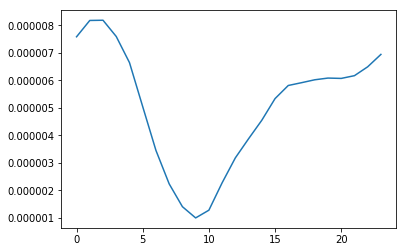

In [69]:
meanhour=[]
for i in hourcsv.columns:
    if i != 'tract':
        meanhour.append(np.mean(output[i]/output['total_tweets']))
plt.plot(meanhour) 
# 0 is 12AM - 23 is 11PM
print('There are alot of tweets that occurred at night and after noon')

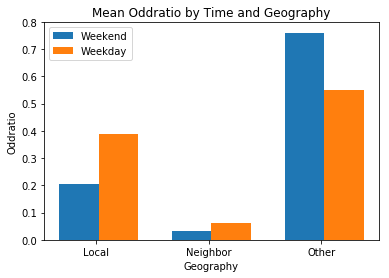

In [88]:
n = np.arange(3)
bar_width = 0.35
plt.bar(n, [np.mean(output['local_weekend_oddratio']),
          np.mean(output['neighbor_weekend_oddratio']),
          np.mean(output['other_weekend_oddratio'])], bar_width, 
            label = "Weekend" )
plt.bar(n + bar_width, [np.mean(output['local_weekday_oddratio']), 
          np.mean(output['neighbor_weekday_oddratio']),
          np.mean(output['other_weekday_oddratio'])], bar_width,
       label = 'Weekday')
plt.xlabel("Geography")
plt.ylabel("Oddratio")
plt.xticks(n+ 0.15, ['Local', 'Neighbor', 'Other'])
plt.title("Mean Oddratio by Time and Geography")
plt.legend();

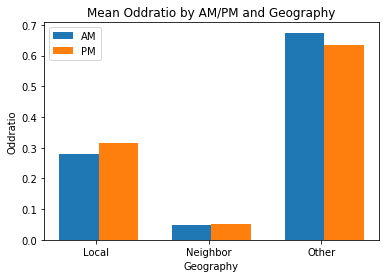

In [89]:
n = np.arange(3)
bar_width = 0.35
plt.bar(n, [np.mean(output['local_daytime_oddratio']),
          np.mean(output['neighbor_daytime_oddratio']),
          np.mean(output['other_daytime_oddratio'])], bar_width, 
            label = "AM" )
plt.bar(n + bar_width, [np.mean(output['local_nighttime_oddratio']), 
          np.mean(output['neighbor_nighttime_oddratio']),
          np.mean(output['other_nighttime_oddratio'])], bar_width,
       label = 'PM')
plt.xlabel("Geography")
plt.ylabel("Oddratio")
plt.xticks(n+ 0.15, ['Local', 'Neighbor', 'Other'])
plt.title("Mean Oddratio by AM/PM and Geography")
plt.legend();